- competition/dataset : [https://www.kaggle.com/c/data-science-bowl-2018](https://www.kaggle.com/c/data-science-bowl-2018)
- date : 2021/03/03
- original : [https://www.kaggle.com/aharless/xgboost-lightgbm-and-ols-and-nn](https://www.kaggle.com/aharless/xgboost-lightgbm-and-ols-and-nn)

## Teaching notebook for total imaging newbies

**✏ 필사 1회** 

이 커널은 전통적인 이미지 기술을 사용하며, 이미지 데이터를 다뤄보지 않은 사람들에게 유용한 프라이머 역할을 하기 바랍니다. 궁극적으로 우리는 테스트 이미지에 적용할 수 있는 ```scipy```와 ```numpy``` (그리고 약간의 ```scikit-image```)를 사용하여 간단한 파이프라인을 만들 것입니다. 사실, 파라미터를 최적화시키는 것 외에는 트레이닝 이미지조차 사용하지 않을 것입니다.  

In [16]:
import pathlib
import imageio
import numpy as np
import warnings
warnings.filterwarnings('ignore')

training_paths = pathlib.Path('data/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

### Dealing with color
이 데이터 셋의 이미지들은 획득되는 'modality(기준값)'을 기준으로 RGB, RGBA, 그레이스케일 형식일 수 있습니다. 컬러 이미지의 경우 'channel'(Red, Green, Blue 등)을 인코딩하는 세 번째 차원이 있습니다. 첫 번째 패스를 위해 간단히 만들기 위해 우리는 ```scikit-image```의 ```rgb2gray``` 함수를 사용하여 모든 이미지를 강제로 그레이스케일로 변환할 수 있습니다.

In [17]:
# 이미지 차원
print('Original image shape: {}'.format(im.shape))

# grayscale로 변환
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


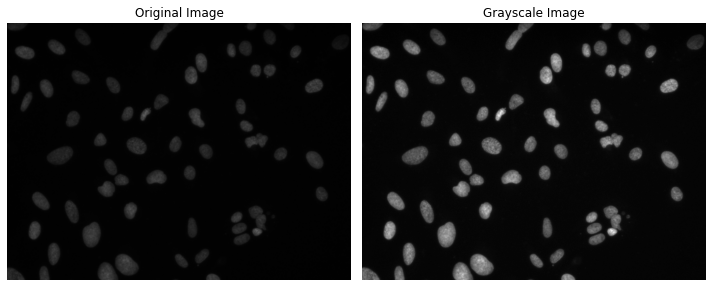

In [18]:
# 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()  # 서브 플롯 사이 간격을 자동으로 유지
plt.show()

### Removing backgraound
아마 이 문제에 대한 가장 간단한 접근법은 이미지에 관심있는 것과 배경, 두 가지 클래스가 있다고 가정하는 것일 수 있습니다. 이러한 전제 하에 우리는 데이터가 두 가지의 강도 분포로 분류될 것이라고 예상할 수 있습니다. 만약 최적의 분리 값을 찾는다면, 배경 데이터를 마스킹한 후 남은 객체들을 세면 됩니다.  

임계값을 찾는 가장 바보 같은 방법은 평균이나 중간값 같은 기술 통계를 사용하는 것입니다. 그러나 다른 좋은 방법이 있습니다. Otsu 방법은 이미지를 두 가지 분포로 모델링하고 최적의 분리 값을 찾는데 유용합니다.

In [19]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0) # thresh_val보다 큰 값은 1, 아닌 값은 0

# mask의 대부분이 배경인지 확인
if np.sum(mask == 0) < np.sum(mask == 1):
    mask = np.where(mask, 0, 1)

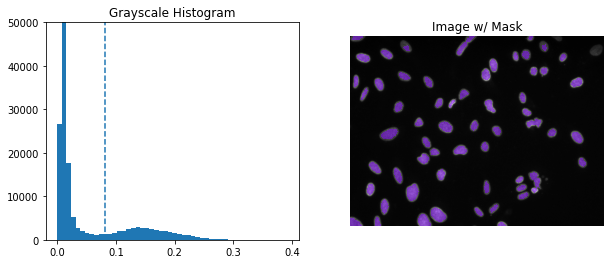

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins=50)
plt.vlines(thresh_val, 0, 50000, linestyle='--')
plt.ylim([0, 50000])
plt.title('Grayscale Histogram')

plt.subplot(1, 2, 2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')
plt.show()

### Deriving individual masks for each object
이 대회에서는 각 핵에 대한 별도의 마스크를 사용해야 합니다. 할 수 있는 한 가지 방법은 마스크에서 연결된 모든 개체를 찾은 뒤 ```ndimage.label```을 사용하여 각각을 할당하는 것입니다. 그 다음 각각의 ```label_id```를 반복하며 리스트에 추가할 수 있습니다.

In [21]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels==label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


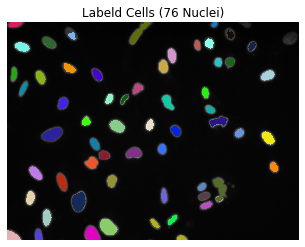

In [22]:
# random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256, 3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeld Cells ({} Nuclei)'.format(nlabels))
plt.show()

두 가지 문제점:  
* 몇 개의 픽셀들이 독립되어 있음  
* 몇 개의 셀들이 하나의 마스크로 결합되어 있음  

```ndimage.find_objects```를 사용하여 마스크 하나하나씩 부가적인 처리 절차를 적용해야 할 핵들을 살펴볼 수 있습니다. ```find_objects```는 이미지에서 레이블링된 개체 각각에 대한 좌표 범위의 리스트를 리턴합니다.

In [23]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # 레이블 크기가 너무 작지는 않은지 확인
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels == label_ind+1, 0, mask)

# 레이블 재생성
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


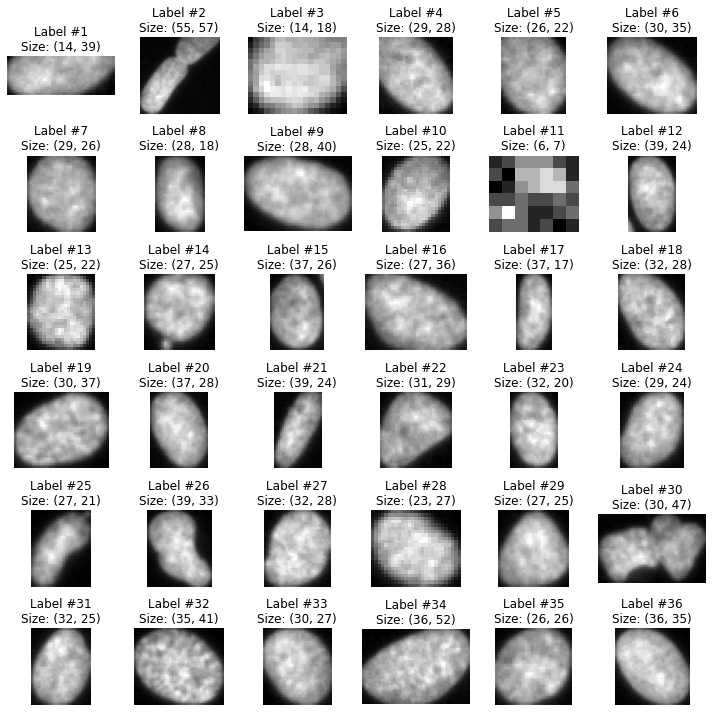

In [24]:
fig, ax = plt.subplots(6, 6, figsize=(10, 10))
for i, obj_indices in enumerate(ndimage.find_objects(labels)[:36]):
    cell = im_gray[obj_indices]
    ax[i//6, i%6].imshow(cell, cmap='gray')
    ax[i//6, i%6].axis('off')
    ax[i//6, i%6].set_title('Label #{}\nSize: {}'.format(i+1, cell.shape))

plt.tight_layout()
plt.show()

Label \#2는 셀이 서로 인접한 문제가 있습니다: 두 셀이 같은 개체로 인식되었습니다. 이때 할 수 있는 것은 두 셀 사이의 차이를 확인하기 위해 마스크를 축소할 수 있는지 보는 것입니다. 이것을 mask erosion(마스크 침식)이라고 합니다. 그 다음 원래의 비율로 복구하기 위해 다시 키울 수 있습니다.

In [25]:
# 인덱스를 가져온 뒤, binary opening procedure 수행
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

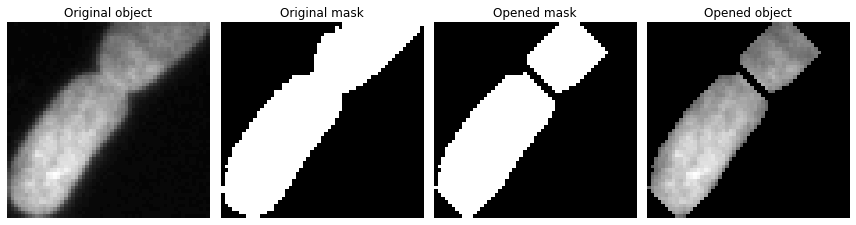

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].imshow(im_gray[two_cell_indices], cmap='gray')
ax[0].set_title('Original object')
ax[1].imshow(mask[two_cell_indices], cmap='gray')
ax[1].set_title('Original mask')
ax[2].imshow(cell_mask_opened, cmap='gray')
ax[2].set_title('Opened mask')
ax[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
ax[3].set_title('Opened object')

for i in ax:
    i.axis('off')
plt.tight_layout()
plt.show()

### Convert each labeled object to Run Line Encoding
마지막으로, 각 ```label_mask```를 각각 'run lined encoded' 문자열로 인코딩해야 합니다. 기본적으로 우리는 array를 사용했기 때문에, 마스크의 일부분에서 픽셀을 찾고자 할 때 인덱싱하고 마스크의 일부인 픽셀 수를 계산합니다. 그리고 새로운 픽셀 시작점을 볼 대마다 이 과정을 반복합니다.  

[Rakhlin의 커널](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python)에서 RLE에 대한 훌륭한 함수를 발견했습니다.

In [27]:
def rle_encoding(x):
    '''
    x: (높이, 너비) 형태의 numpy array, 1-mask, 0-background
    return: 리스트 형태의 run length
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


### Combine it into a single function
이미지를 덤프 방식으로 처리하는 기본 단계를 보았기 때문에, 우리는 모든 것을 하나의 함수로 합칠 수 있습니다. 이 함수는 이미지 경로를 받아서 위에서 설명한 절차를 수행한 뒤, 발견된 각 마스크에 대해 RLE 문자열로 된 데이터프레임을 리턴합니다.

In [28]:
import pandas as pd
def analyze_image(im_path):
    # 데이터 읽기, grayscale로 변환
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    
    # 배경 구분, 연결된 객체 추출
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask == 0) < np.sum(mask == 1):
        mask = np.where(mask, 0, 1)
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # 각 레이블을 반복하며 데이터프레임에 추가
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels==label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId':im_id, 'EncodedPixels':rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df

In [29]:
def analyze_list_of_images(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [32]:
testing = pathlib.Path('data/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('data/submission_1.csv', index=None)